Max amplitude of x1,x2 = 33.52486088538897


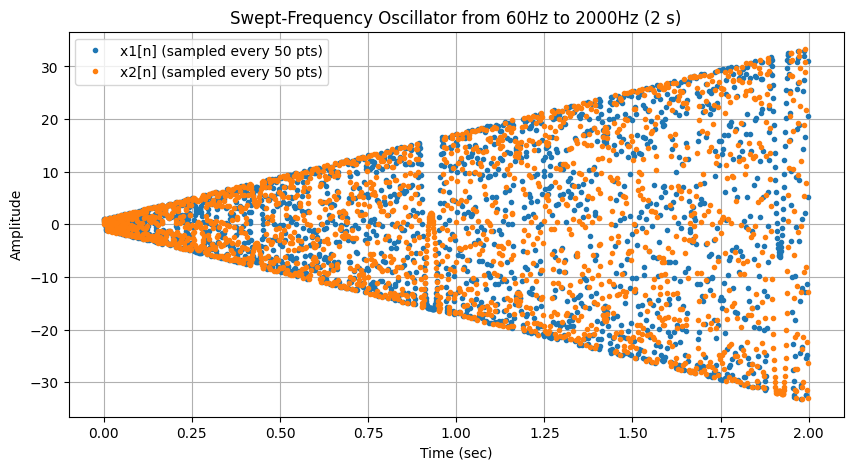

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fs = 48000           # sample rate (Hz)
T  = 2.0             # duration (seconds)
N  = int(fs * T)     # total number of samples

# Sweep linearly from 60 Hz to 2000 Hz over N samples:
n_array = np.arange(N)
f_start, f_end = 60.0, 2000.0
f_array = f_start + (f_end - f_start)*n_array/(N - 1)

# Convert to digital radian frequency w[n] = 2*pi*(f[n]/fs)
w_array = 2.0*np.pi*f_array/fs

# Allocate arrays for the two states (in-phase, quadrature)
x1 = np.zeros(N)   # "cos" component
x2 = np.zeros(N)   # "sin" (quadrature) component

# Initial conditions (amplitude=1 at n=0)
x1[0] = 1.0
x2[0] = 0.0

for n in range(1, N):
    w_new = w_array[n]
    w_old = w_array[n - 1]
    
    # Midpoint angle for the rotation
    w_mid = 0.5*(w_new + w_old)
    
    # The "gain" that keeps amplitude the same despite frequency change
    denom = np.tan(w_old/2.0)
    if abs(denom) < 1.0e-12:
        G = 1.0
    else:
        G = np.tan(w_new/2.0)/denom
    
    # Standard rotation matrix with minus in the top row, plus in the bottom row
    c = np.cos(w_mid)
    s = np.sin(w_mid)
    
    x1_old = x1[n - 1]
    x2_old = x2[n - 1]
    
    # Update states
    x1[n] = G*( x1_old*c - x2_old*s )
    x2[n] = G*( x1_old*s + x2_old*c )

# --- Check amplitude ---
amp = np.sqrt(x1**2 + x2**2)
print("Max amplitude of x1,x2 =", np.max(amp))

# --- Plot with fewer points (to avoid a 'solid wedge') ---
t = np.arange(N)/fs
plt.figure(figsize=(10,5))
plt.plot(t[::50], x1[::50], '.', label='x1[n] (sampled every 50 pts)')
plt.plot(t[::50], x2[::50], '.', label='x2[n] (sampled every 50 pts)')
plt.title("Swept-Frequency Oscillator from 60Hz to 2000Hz (2 s)")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

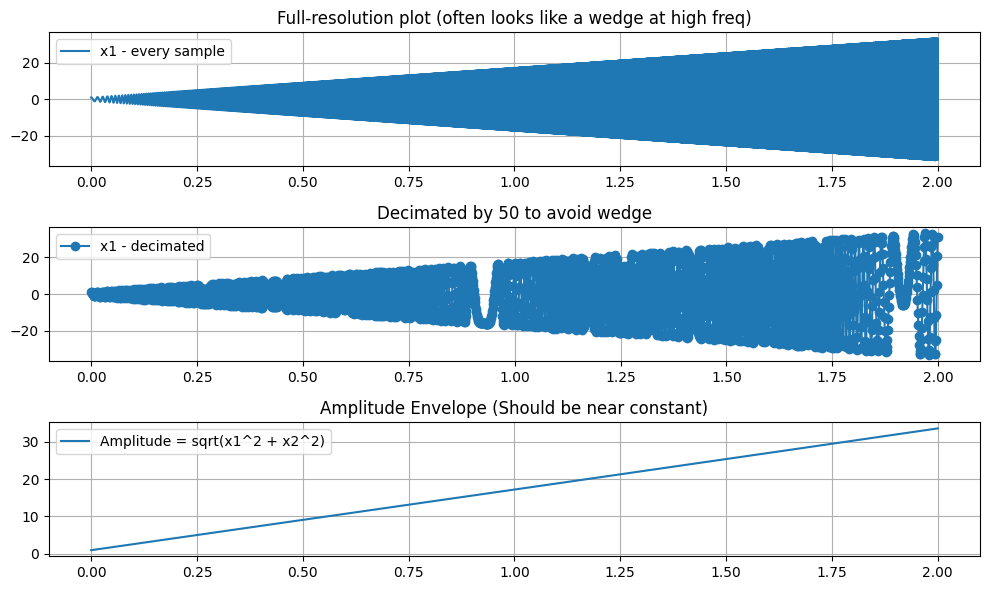

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose x1, x2 hold your oscillator states
# Suppose t is the time axis, same length as x1, x2
# We'll skip the oscillator generation here, assuming you have it.

amp = np.sqrt(x1**2 + x2**2)

plt.figure(figsize=(10,6))

# 1) Plot every sample - usually yields a "filled wedge"
plt.subplot(3,1,1)
plt.plot(t, x1, label='x1 - every sample')
plt.title('Full-resolution plot (often looks like a wedge at high freq)')
plt.legend()
plt.grid(True)

# 2) Plot decimated samples to see actual sample amplitudes
plt.subplot(3,1,2)
step = 50  # or 100
plt.plot(t[::step], x1[::step], 'o-', label='x1 - decimated')
plt.title(f'Decimated by {step} to avoid wedge')
plt.legend()
plt.grid(True)

# 3) Plot amplitude envelope
plt.subplot(3,1,3)
plt.plot(t, amp, label='Amplitude = sqrt(x1^2 + x2^2)')
plt.title('Amplitude Envelope (Should be near constant)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Output amplitude: min = 0.000002, max = 1.000000


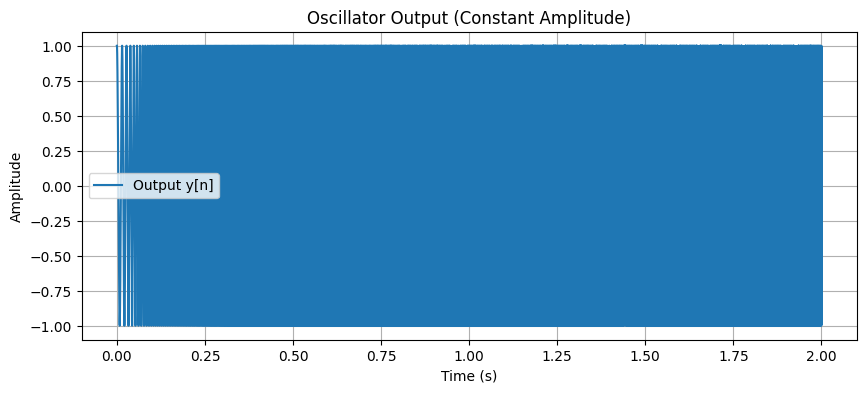

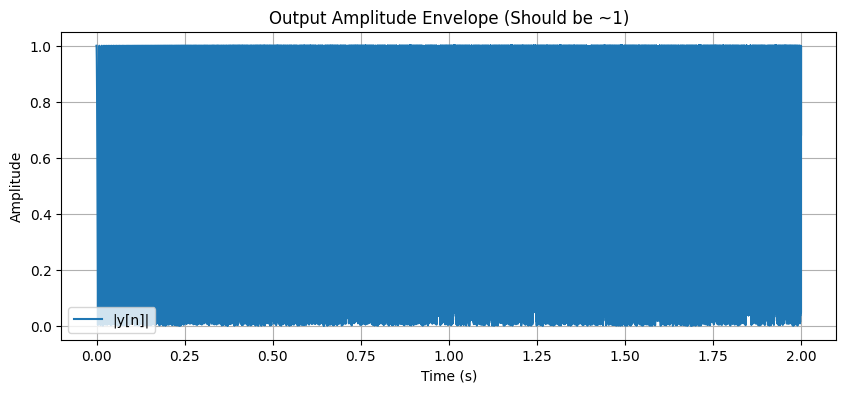

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
fs = 48000.0          # Sample rate (Hz)
T = 2.0               # Duration (seconds)
N = int(fs * T)       # Number of samples

# --- Frequency sweep: 60 Hz to 2000 Hz ---
n_array = np.arange(N)
f_start = 60.0
f_end = 2000.0
f_array = f_start + (f_end - f_start)*n_array/(N - 1)

# --- Compute the bilinear digital angle ---
# Note: The bilinear mapping is essential.
#   analog rad/s: omega_a = 2*pi*f
#   digital (warped) angle: w = 2*atan(omega_a/(2*fs))
omega_a = 2.0 * np.pi * f_array
w = 2.0 * np.arctan( omega_a/(2.0*fs) )

# --- Allocate state variables for the oscillator ---
x1 = np.zeros(N)
x2 = np.zeros(N)
x1[0] = 1.0  # initial condition (unit amplitude)
x2[0] = 0.0

# --- Oscillator state update ---
# Use the “midpoint” angle and G[n] as given.
for n in range(1, N):
    w_old = w[n-1]
    w_new = w[n]
    w_mid = 0.5*(w_old + w_new)
    
    # Compute G[n] exactly as given
    denom = np.tan(w_old/2.0)
    if abs(denom) < 1e-12:
        G = 1.0
    else:
        G = np.tan(w_new/2.0) / denom

    # Update both states (this is the internal “rotating phasor”)
    x1[n] = G * ( x1[n-1]*np.cos(w_mid) - x2[n-1]*np.sin(w_mid) )
    x2[n] = G * ( x1[n-1]*np.sin(w_mid) + x2[n-1]*np.cos(w_mid) )

# --- Define the output node ---
# The cumulative product of G's is tan(w[n]/2)/tan(w[0]/2),
# so we cancel it by multiplying x1[n] by tan(w[0]/2)/tan(w[n]/2)
y = x1 * ( np.tan(w[0]/2.0) / np.tan(w/2.0) )

# --- Verify amplitude ---
amp = np.abs(y)
print("Output amplitude: min = {:.6f}, max = {:.6f}".format(amp.min(), amp.max()))

# --- Plot the output waveform and its amplitude envelope ---
t = n_array / fs

plt.figure(figsize=(10,4))
plt.plot(t, y, label='Output y[n]')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Oscillator Output (Constant Amplitude)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, amp, label='|y[n]|')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Output Amplitude Envelope (Should be ~1)")
plt.legend()
plt.grid(True)
plt.show()